In [1]:
import pandas as pd
import numpy
import requests
import json
import datetime
import dateutil.parser
import pytz
from typing import Optional, Union
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# An api key is emailed to you when you sign up to a plan
# Get a free API key at https://api.the-odds-api.com/
API_KEY = 'ccb83d4bc10da89dbfa3dc2135ba9c1a'

SPORT = 'upcoming' # use the sport_key from the /sports endpoint below, or use 'upcoming' to see the next 8 games across all sports

REGIONS = 'us' # uk | us | eu | au. Multiple can be specified if comma delimited

MARKETS = 'h2h' # h2h | spreads | totals. Multiple can be specified if comma delimited

ODDS_FORMAT = 'american' # decimal | american

DATE_FORMAT = 'iso' # iso | unix

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# First get a list of in-season sports
#   The sport 'key' from the response can be used to get odds in the next request
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

sports_response = requests.get(
    'https://api.the-odds-api.com/v4/sports',
    params={
        'api_key': API_KEY
    }
)


if sports_response.status_code != 200:
    print(f'Failed to get sports: status_code {sports_response.status_code}, response body {sports_response.text}')

else:
    print('List of in season sports:', sports_response.json())


List of in season sports: [{'key': 'americanfootball_cfl', 'group': 'American Football', 'title': 'CFL', 'description': 'Canadian Football League', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf', 'group': 'American Football', 'title': 'NCAAF', 'description': 'US College Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf_championship_winner', 'group': 'American Football', 'title': 'NCAAF Championship Winner', 'description': 'US College Football Championship Winner', 'active': True, 'has_outrights': True}, {'key': 'americanfootball_nfl', 'group': 'American Football', 'title': 'NFL', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_preseason', 'group': 'American Football', 'title': 'NFL Preseason', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_super_bowl_winner', 'group': 'American Football', 'title': 'NFL Super Bowl Winner'

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# Now get a list of live & upcoming games for the sport you want, along with odds for different bookmakers
# This will deduct from the usage quota
# The usage quota cost = [number of markets specified] x [number of regions specified]
# For examples of usage quota costs, see https://the-odds-api.com/liveapi/guides/v4/#usage-quota-costs

SPORT = 'baseball_mlb'

odds_response = requests.get(
    f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds',
    params={
        'api_key': API_KEY,
        'regions': REGIONS,
        'markets': MARKETS,
        'oddsFormat': ODDS_FORMAT,
        'dateFormat': DATE_FORMAT,
    }
)

if odds_response.status_code != 200:
    print(f'Failed to get odds: status_code {odds_response.status_code}, response body {odds_response.text}')

else:
    odds_json = odds_response.json()
    print('Number of events:', len(odds_json))
    print(odds_json)


Number of events: 25
[{'id': '4b6bbb0e6e5e83e79c17eade41e8bc64', 'sport_key': 'baseball_mlb', 'sport_title': 'MLB', 'commence_time': '2024-08-12T22:41:00Z', 'home_team': 'Cleveland Guardians', 'away_team': 'Chicago Cubs', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'last_update': '2024-08-12T22:57:01Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-12T22:57:01Z', 'outcomes': [{'name': 'Chicago Cubs', 'price': -136}, {'name': 'Cleveland Guardians', 'price': 106}]}]}, {'key': 'draftkings', 'title': 'DraftKings', 'last_update': '2024-08-12T22:57:00Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-12T22:57:00Z', 'outcomes': [{'name': 'Chicago Cubs', 'price': -130}, {'name': 'Cleveland Guardians', 'price': 100}]}]}, {'key': 'bovada', 'title': 'Bovada', 'last_update': '2024-08-12T22:57:01Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-12T22:57:01Z', 'outcomes': [{'name': 'Chicago Cubs', 'price': -130}, {'name': 'Cleveland Guardians', 'price': 100}]}]}, {'key': 'bet

In [5]:
# Check the usage quota
print('Remaining requests', odds_response.headers['x-requests-remaining'])
print('Used requests', odds_response.headers['x-requests-used'])


Remaining requests 479
Used requests 21


In [6]:
#set up the columns
columns = [
        'event_id', 'sport_key', 'sport_title', 'commence_time',
        'home_team', 'away_team', 'bookmaker_key', 'bookmaker_title',
        'bookmaker_last_update', 'market_key', 'market_last_update',
        'outcome_name', 'outcome_price']

df2 = pd.DataFrame(columns=columns)

# Prepare list to collect all rows
all_rows = []

# Iterate over each event
for event in odds_json:
        event_id = event['id']
        sport_key = event['sport_key']
        sport_title = event['sport_title']
        commence_time = event['commence_time']
        home_team = event['home_team']
        away_team = event['away_team']

        # Iterate over each bookmaker
        for bookmaker in event['bookmakers']:
            bookmaker_key = bookmaker['key']
            bookmaker_title = bookmaker['title']
            bookmaker_last_update = bookmaker['last_update']

            # Iterate over each market
            for market in bookmaker['markets']:
                market_key = market['key']
                market_last_update = market['last_update']

                # Iterate over each outcome
                for outcome in market['outcomes']:
                    outcome_name = outcome['name']
                    outcome_price = outcome['price']

                    # Append the row to the list
                    all_rows.append([
                        event_id, sport_key, sport_title, commence_time,
                        home_team, away_team, bookmaker_key, bookmaker_title,
                        bookmaker_last_update, market_key, market_last_update,
                        outcome_name, outcome_price
                    ])
for i, row in enumerate(all_rows):
    df2.loc[i] = row

In [7]:
df2

,event_id,sport_key,sport_title,commence_time,home_team,away_team,bookmaker_key,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,4b6bbb0e6e5e83e79c17eade41e8bc64,baseball_mlb,MLB,2024-08-12T22:41:00Z,Cleveland Guardians,Chicago Cubs,fanduel,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Chicago Cubs,-136
1,4b6bbb0e6e5e83e79c17eade41e8bc64,baseball_mlb,MLB,2024-08-12T22:41:00Z,Cleveland Guardians,Chicago Cubs,fanduel,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Cleveland Guardians,106
2,4b6bbb0e6e5e83e79c17eade41e8bc64,baseball_mlb,MLB,2024-08-12T22:41:00Z,Cleveland Guardians,Chicago Cubs,draftkings,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Chicago Cubs,-130
3,4b6bbb0e6e5e83e79c17eade41e8bc64,baseball_mlb,MLB,2024-08-12T22:41:00Z,Cleveland Guardians,Chicago Cubs,draftkings,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Cleveland Guardians,100
4,4b6bbb0e6e5e83e79c17eade41e8bc64,baseball_mlb,MLB,2024-08-12T22:41:00Z,Cleveland Guardians,Chicago Cubs,bovada,Bovada,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Chicago Cubs,-130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0c379ecda5467def480313d43d26292f,baseball_mlb,MLB,2024-08-14T01:45:00Z,San Francisco Giants,Atlanta Braves,fanduel,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,San Francisco Giants,102
300,0c379ecda5467def480313d43d26292f,baseball_mlb,MLB,2024-08-14T01:45:00Z,San Francisco Giants,Atlanta Braves,draftkings,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Atlanta Braves,-112
301,0c379ecda5467def480313d43d26292f,baseball_mlb,MLB,2024-08-14T01:45:00Z,San Francisco Giants,Atlanta Braves,draftkings,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,San Francisco Giants,-108
302,0c379ecda5467def480313d43d26292f,baseball_mlb,MLB,2024-08-14T01:45:00Z,San Francisco Giants,Atlanta Braves,bovada,Bovada,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Atlanta Braves,-113


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 0 to 303
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   event_id               304 non-null    object
 1   sport_key              304 non-null    object
 2   sport_title            304 non-null    object
 3   commence_time          304 non-null    object
 4   home_team              304 non-null    object
 5   away_team              304 non-null    object
 6   bookmaker_key          304 non-null    object
 7   bookmaker_title        304 non-null    object
 8   bookmaker_last_update  304 non-null    object
 9   market_key             304 non-null    object
 10  market_last_update     304 non-null    object
 11  outcome_name           304 non-null    object
 12  outcome_price          304 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 41.4+ KB


In [9]:
df2.duplicated().sum()

0

In [10]:
df2.duplicated().value_counts()

,count
False,304


In [11]:
df2.drop_duplicates(inplace=True)

In [12]:
df2.duplicated().sum()

0

In [13]:
df2.isnull().sum()

,0
event_id,0
sport_key,0
sport_title,0
commence_time,0
home_team,0
away_team,0
bookmaker_key,0
bookmaker_title,0
bookmaker_last_update,0
market_key,0


In [14]:
df2= df2.drop(columns = ['event_id', 'commence_time', 'bookmaker_key'])
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Chicago Cubs,-136
1,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Cleveland Guardians,106
2,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Chicago Cubs,-130
3,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Cleveland Guardians,100
4,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,Bovada,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Chicago Cubs,-130
...,...,...,...,...,...,...,...,...,...,...
299,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,San Francisco Giants,102
300,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,Atlanta Braves,-112
301,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,2024-08-12T22:57:00Z,h2h,2024-08-12T22:57:00Z,San Francisco Giants,-108
302,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,2024-08-12T22:57:01Z,h2h,2024-08-12T22:57:01Z,Atlanta Braves,-113


In [15]:
# Convert the columns to datetime
df2['bookmaker_last_update'] = pd.to_datetime(df2['bookmaker_last_update'])
df2['market_last_update'] = pd.to_datetime(df2['market_last_update'])

# Format the datetime columns
df2['bookmaker_last_update'] = df2['bookmaker_last_update'].dt.strftime('%b %d, %H:%M')
df2['market_last_update'] = df2['market_last_update'].dt.strftime('%b %d, %H:%M')
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-136
1,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,106
2,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130
3,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,100
4,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130
...,...,...,...,...,...,...,...,...,...,...
299,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,102
300,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-112
301,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-108
302,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-113


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 0 to 303
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sport_key              304 non-null    object
 1   sport_title            304 non-null    object
 2   home_team              304 non-null    object
 3   away_team              304 non-null    object
 4   bookmaker_title        304 non-null    object
 5   bookmaker_last_update  304 non-null    object
 6   market_key             304 non-null    object
 7   market_last_update     304 non-null    object
 8   outcome_name           304 non-null    object
 9   outcome_price          304 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 34.2+ KB


In [17]:
def av_odds(df2):
    # Define key columns for grouping
    key_fields = ['home_team', 'away_team', 'bookmaker_title', 'outcome_name']

    # Perform aggregation by calculating the average outcome_price
    df_avg = df2.groupby(key_fields, dropna=False).agg({
        'outcome_price': 'mean'  # Average outcome_price
    }).reset_index()

    # Sort the aggregated DataFrame by key fields
    df_avg.sort_values(['home_team','away_team'], inplace=True)

    return df_avg



In [18]:
df_avg_odds = av_odds(df2)
df_avg_odds

,home_team,away_team,bookmaker_title,outcome_name,outcome_price
0,Arizona Diamondbacks,Colorado Rockies,BetMGM,Arizona Diamondbacks,-300.0
1,Arizona Diamondbacks,Colorado Rockies,BetMGM,Colorado Rockies,240.0
2,Arizona Diamondbacks,Colorado Rockies,BetOnline.ag,Arizona Diamondbacks,-257.5
3,Arizona Diamondbacks,Colorado Rockies,BetOnline.ag,Colorado Rockies,228.0
4,Arizona Diamondbacks,Colorado Rockies,BetRivers,Arizona Diamondbacks,-305.0
...,...,...,...,...,...
199,Tampa Bay Rays,Houston Astros,FanDuel,Tampa Bay Rays,129.0
200,Tampa Bay Rays,Houston Astros,LowVig.ag,Houston Astros,-124.5
201,Tampa Bay Rays,Houston Astros,LowVig.ag,Tampa Bay Rays,114.5
202,Tampa Bay Rays,Houston Astros,MyBookie.ag,Houston Astros,-159.5


In [22]:
#general average odds for the home team only
avg_odds = df2.groupby('home_team')['outcome_price'].mean()
avg_odds

,outcome_price
home_team,
Arizona Diamondbacks,-23.535714
Baltimore Orioles,-12.714286
Boston Red Sox,-8.533333
Chicago White Sox,-30.535714
Cincinnati Reds,-12.541667
Cleveland Guardians,-30.000000
Los Angeles Angels,-72.428571
Milwaukee Brewers,-72.071429
Minnesota Twins,-20.600000


In [24]:
# top 5 highest standard deviation.A higher SD indicates a mix of very high and very low vigors
std_dev_odds = df2.groupby('outcome_name')['outcome_price'].std()
std_dev_odds.nlargest(5)

,outcome_price
outcome_name,
St. Louis Cardinals,140.633712
Cincinnati Reds,132.651514
Los Angeles Angels,115.349945
Cleveland Guardians,113.300780
Milwaukee Brewers,105.285588


In [25]:
#Lower standard deviation indicates vigors more closely consistent with each other.
std_dev_odds.nsmallest(5)

,outcome_price
outcome_name,
Washington Nationals,4.825527
Pittsburgh Pirates,4.936965
Atlanta Braves,5.552942
Baltimore Orioles,6.271629
Los Angeles Dodgers,6.955115


In [27]:
#min and max odds sorted by outcome_price
min_odds = df2.groupby('outcome_name')['outcome_price'].min().sort_values()
max_odds = df2.groupby('outcome_name')['outcome_price'].max().sort_values(ascending=False)

print("**Minimum Odds:**")
print(min_odds)
print("")
print("**Maximum Odds:**")
print(max_odds)

**Minimum Odds:**
outcome_name
New York Yankees        -360
Arizona Diamondbacks    -305
San Diego Padres        -212
Houston Astros          -186
Philadelphia Phillies   -178
St. Louis Cardinals     -175
Baltimore Orioles       -175
Minnesota Twins         -167
New York Mets           -166
Boston Red Sox          -150
Toronto Blue Jays       -148
Cincinnati Reds         -140
Chicago Cubs            -136
Los Angeles Dodgers     -126
Cleveland Guardians     -122
Atlanta Braves          -120
San Francisco Giants    -116
Kansas City Royals      -116
Los Angeles Angels      -115
Milwaukee Brewers       -112
Texas Rangers            102
Tampa Bay Rays           110
Washington Nationals     136
Oakland Athletics        140
Miami Marlins            150
Pittsburgh Pirates       160
Colorado Rockies         198
Chicago White Sox        245
Name: outcome_price, dtype: int64

**Maximum Odds:**
outcome_name
Chicago White Sox        286
Colorado Rockies         245
Pittsburgh Pirates       176
Wash

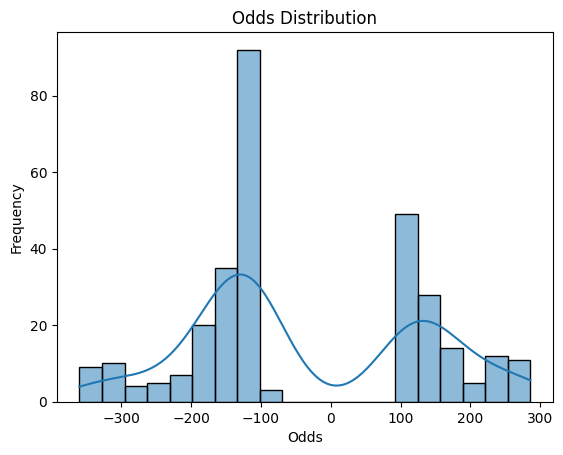

In [28]:
#number of times each team is placed within the odds
sns.histplot(df2['outcome_price'], bins=20, kde=True)
plt.xlabel('Odds')
plt.ylabel('Frequency')
plt.title('Odds Distribution')
plt.show()


In [23]:
home_odds = df2[df2['home_team'] == 'TeamName']['outcome_price'].mean()
away_odds = df2[df2['away_team'] == 'TeamName']['outcome_price'].mean()
print(home_odds)
print(away_odds)

nan
nan


In [29]:
# Grouping by 'bookmaker_title' and including 'home_team'
bookmaker_odds = df2.groupby(['bookmaker_title', 'home_team'])['outcome_price'].apply(list).reset_index()

# Display the odds
bookmaker_odds


,bookmaker_title,home_team,outcome_price
0,BetMGM,Arizona Diamondbacks,"[-300, 240]"
1,BetMGM,Baltimore Orioles,"[-175, 145]"
2,BetMGM,Boston Red Sox,"[-125, 105, -150, 125]"
3,BetMGM,Chicago White Sox,"[270, -350]"
4,BetMGM,Cincinnati Reds,"[135, -165, -140, 115]"
...,...,...,...
97,MyBookie.ag,Milwaukee Brewers,"[-104, -112]"
98,MyBookie.ag,Minnesota Twins,"[141, -167]"
99,MyBookie.ag,San Diego Padres,"[169, -200]"
100,MyBookie.ag,San Francisco Giants,"[-105, -111]"


In [30]:
def calculate_implied_probability(odd):
    if odd < 0:
        return ((-1 * odd) / ((-1 * odd) + 100)) * 100
    else:
        return (100 / (odd + 100)) * 100

In [31]:
# Apply the function to calculate implied probability and add it to the DataFrame
df2['implied_probability'] = df2['outcome_price'].apply(calculate_implied_probability)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability
0,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-136,57.627119
1,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,106,48.543689
2,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130,56.521739
3,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,100,50.000000
4,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130,56.521739
...,...,...,...,...,...,...,...,...,...,...,...
299,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,102,49.504950
300,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-112,52.830189
301,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-108,51.923077
302,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-113,53.051643


In [32]:
def calculate_vigor(row):
    home_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['home_team'])]['implied_probability'].values[0]
    away_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['away_team'])]['implied_probability'].values[0]
    vigor = home_team_implied_prob + away_team_implied_prob - 100
    return f"{vigor:.2f}%"

#Apply the function to calculate overround for each bookmaker
df2['vigor'] = df2.apply(calculate_vigor, axis=1)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor
0,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-136,57.627119,6.17%
1,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,106,48.543689,6.17%
2,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130,56.521739,6.52%
3,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Cleveland Guardians,100,50.000000,6.52%
4,baseball_mlb,MLB,Cleveland Guardians,Chicago Cubs,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Chicago Cubs,-130,56.521739,6.52%
...,...,...,...,...,...,...,...,...,...,...,...,...
299,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,102,49.504950,4.20%
300,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-112,52.830189,4.75%
301,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-108,51.923077,4.75%
302,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-113,53.051643,4.76%


In [33]:
df2['vigor'] = df2['vigor'].str.replace('%', '').astype(float)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 0 to 303
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sport_key              304 non-null    object 
 1   sport_title            304 non-null    object 
 2   home_team              304 non-null    object 
 3   away_team              304 non-null    object 
 4   bookmaker_title        304 non-null    object 
 5   bookmaker_last_update  304 non-null    object 
 6   market_key             304 non-null    object 
 7   market_last_update     304 non-null    object 
 8   outcome_name           304 non-null    object 
 9   outcome_price          304 non-null    int64  
 10  implied_probability    304 non-null    float64
 11  vigor                  304 non-null    float64
dtypes: float64(2), int64(1), object(9)
memory usage: 39.0+ KB


In [35]:
vigor_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='vigor')
vigor_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,
Arizona Diamondbacks,4.41,2.57,4.29,3.88,4.85,4.29,3.99,2.57,4.03
Atlanta Braves,4.76,2.40,4.03,2.40,4.76,4.75,4.20,2.40,3.83
Baltimore Orioles,4.45,2.12,NaN,NaN,4.62,4.45,4.20,2.12,4.96
Boston Red Sox,4.34,2.16,3.63,2.16,4.45,4.14,3.83,2.16,3.92
Chicago Cubs,6.23,NaN,NaN,NaN,6.52,6.52,6.17,NaN,5.21
Chicago White Sox,4.80,2.65,3.84,4.58,4.56,4.23,4.09,2.65,4.02
Cincinnati Reds,4.82,2.01,NaN,NaN,6.44,6.19,5.87,2.01,5.86
Cleveland Guardians,6.23,NaN,NaN,NaN,6.52,6.52,6.17,NaN,5.21
Colorado Rockies,4.41,2.57,4.29,3.88,4.85,4.29,3.99,2.57,4.03


In [36]:
low_vig = df2[df2['vigor'] <=2.10][['outcome_name', 'vigor','bookmaker_title']].sort_values('vigor')
low_vig

,outcome_name,vigor,bookmaker_title
200,Cincinnati Reds,2.01,LowVig.ag
201,St. Louis Cardinals,2.01,LowVig.ag
202,Cincinnati Reds,2.01,BetOnline.ag
203,St. Louis Cardinals,2.01,BetOnline.ag
58,Kansas City Royals,2.07,LowVig.ag
59,Minnesota Twins,2.07,LowVig.ag
60,Kansas City Royals,2.07,BetOnline.ag
61,Minnesota Twins,2.07,BetOnline.ag
160,Pittsburgh Pirates,2.10,BetOnline.ag
161,San Diego Padres,2.10,BetOnline.ag


In [37]:
#Calculate the vig spread of the highest and lowest bookmaker
df2['vig_spread'] = df2.groupby(['outcome_name'])['vigor'].transform(lambda x: x.max() - x.min())
df2.tail(10)

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor,vig_spread
294,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,BetOnline.ag,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-107,51.690821,2.40,2.36
295,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,BetOnline.ag,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-103,50.738916,2.40,2.36
296,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,LowVig.ag,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-107,51.690821,2.40,2.36
297,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,LowVig.ag,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-103,50.738916,2.40,2.36
298,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-120,54.545455,4.20,2.36
299,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,FanDuel,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,102,49.504950,4.20,2.36
300,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-112,52.830189,4.75,2.36
301,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,DraftKings,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-108,51.923077,4.75,2.36
302,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",Atlanta Braves,-113,53.051643,4.76,2.36
303,baseball_mlb,MLB,San Francisco Giants,Atlanta Braves,Bovada,"Aug 12, 22:57",h2h,"Aug 12, 22:57",San Francisco Giants,-107,51.690821,4.76,2.36


In [38]:
#highest to smallest vigor spread as percentages
print(df2[['outcome_name', 'vig_spread']].drop_duplicates().sort_values('vig_spread', ascending=False))

              outcome_name  vig_spread
20          Houston Astros        4.97
21          Tampa Bay Rays        4.97
10         Cincinnati Reds        4.43
11     St. Louis Cardinals        4.43
182      Baltimore Orioles        2.84
183   Washington Nationals        2.84
147       San Diego Padres        2.61
146     Pittsburgh Pirates        2.61
165   San Francisco Giants        2.36
164         Atlanta Braves        2.36
75       Milwaukee Brewers        2.32
74     Los Angeles Dodgers        2.32
111      Toronto Blue Jays        2.31
110     Los Angeles Angels        2.31
39           Texas Rangers        2.29
38          Boston Red Sox        2.29
128   Arizona Diamondbacks        2.28
129       Colorado Rockies        2.28
92       Chicago White Sox        2.15
93        New York Yankees        2.15
57         Minnesota Twins        2.13
56      Kansas City Royals        2.13
0             Chicago Cubs        1.31
1      Cleveland Guardians        1.31
212          Miami Marlin

In [39]:
avg_vig_by_team = df2.groupby('home_team')['vigor'].mean()
avg_vig_by_team.nsmallest(5)

,vigor
home_team,
Boston Red Sox,3.458000
Minnesota Twins,3.512000
San Diego Padres,3.595714
Los Angeles Angels,3.677143
Milwaukee Brewers,3.693571


In [41]:
Implied_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='implied_probability')
Implied_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,
Arizona Diamondbacks,75.000000,71.960784,75.308642,74.025974,73.611111,73.368607,72.794118,71.960784,74.619289
Atlanta Braves,52.380952,50.969789,50.980392,50.248756,52.829139,52.376633,52.520252,50.969789,51.219512
Baltimore Orioles,63.636364,62.121212,NaN,NaN,63.636364,63.636364,61.832061,62.121212,63.636364
Boston Red Sox,57.777778,55.996132,54.128440,54.545455,57.662012,57.599713,56.508585,55.996132,56.521739
Chicago Cubs,57.446809,NaN,NaN,NaN,56.521739,56.521739,53.323363,NaN,52.606635
Chicago White Sox,27.027027,26.765523,26.315789,26.315789,28.006267,27.272727,27.650648,26.765523,25.906736
Cincinnati Reds,50.443262,56.140351,NaN,NaN,50.462535,50.000000,50.614351,56.140351,53.293197
Cleveland Guardians,48.780488,NaN,NaN,NaN,50.000000,50.000000,51.749322,NaN,52.606635
Colorado Rockies,29.411765,30.543450,28.985507,29.850746,31.054405,30.886196,31.271277,30.543450,29.411765


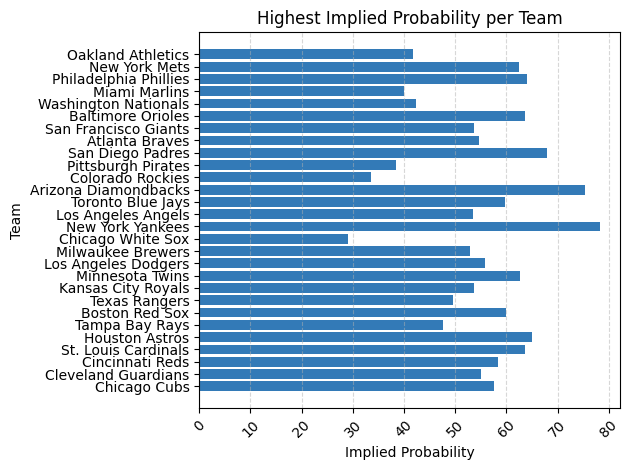

In [42]:
# Assuming the data is in a pandas dataframe called `df`
teams = df2['outcome_name']
implied_probabilities = df2['implied_probability']

plt.barh(teams, implied_probabilities, color='#337ab7')  # blue bars
plt.xlabel('Implied Probability')
plt.ylabel('Team')
plt.title('Highest Implied Probability per Team')
plt.grid(axis='x', linestyle='--', alpha=0.5)  # add a grid
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.tight_layout()  # adjust layout to fit all labels
plt.show()

In [43]:
#Maximum implied probability for all teams
print(df2.loc[df2.groupby('outcome_name')['implied_probability'].idxmax()][['outcome_name', 'implied_probability']])

              outcome_name  implied_probability
132   Arizona Diamondbacks            75.308642
298         Atlanta Braves            54.545455
188      Baltimore Orioles            63.636364
238         Boston Red Sox            60.000000
0             Chicago Cubs            57.627119
248      Chicago White Sox            28.985507
208        Cincinnati Reds            58.333333
197    Cleveland Guardians            54.954955
279       Colorado Rockies            33.557047
20          Houston Astros            65.034965
242     Kansas City Royals            53.703704
124     Los Angeles Angels            53.488372
258    Los Angeles Dodgers            55.752212
212          Miami Marlins            40.000000
79       Milwaukee Brewers            52.830189
73         Minnesota Twins            62.546816
240          New York Mets            62.406015
99        New York Yankees            78.260870
241      Oakland Athletics            41.666667
213  Philadelphia Phillies            64

In [45]:
print(df_avg_odds.head())
print(f'Number of rows in aggregated DataFrame: {df_avg_odds.shape[0]}')


              home_team         away_team bookmaker_title  \
0  Arizona Diamondbacks  Colorado Rockies          BetMGM   
1  Arizona Diamondbacks  Colorado Rockies          BetMGM   
2  Arizona Diamondbacks  Colorado Rockies    BetOnline.ag   
3  Arizona Diamondbacks  Colorado Rockies    BetOnline.ag   
4  Arizona Diamondbacks  Colorado Rockies       BetRivers   

           outcome_name  outcome_price  
0  Arizona Diamondbacks         -300.0  
1      Colorado Rockies          240.0  
2  Arizona Diamondbacks         -257.5  
3      Colorado Rockies          228.0  
4  Arizona Diamondbacks         -305.0  
Number of rows in aggregated DataFrame: 204


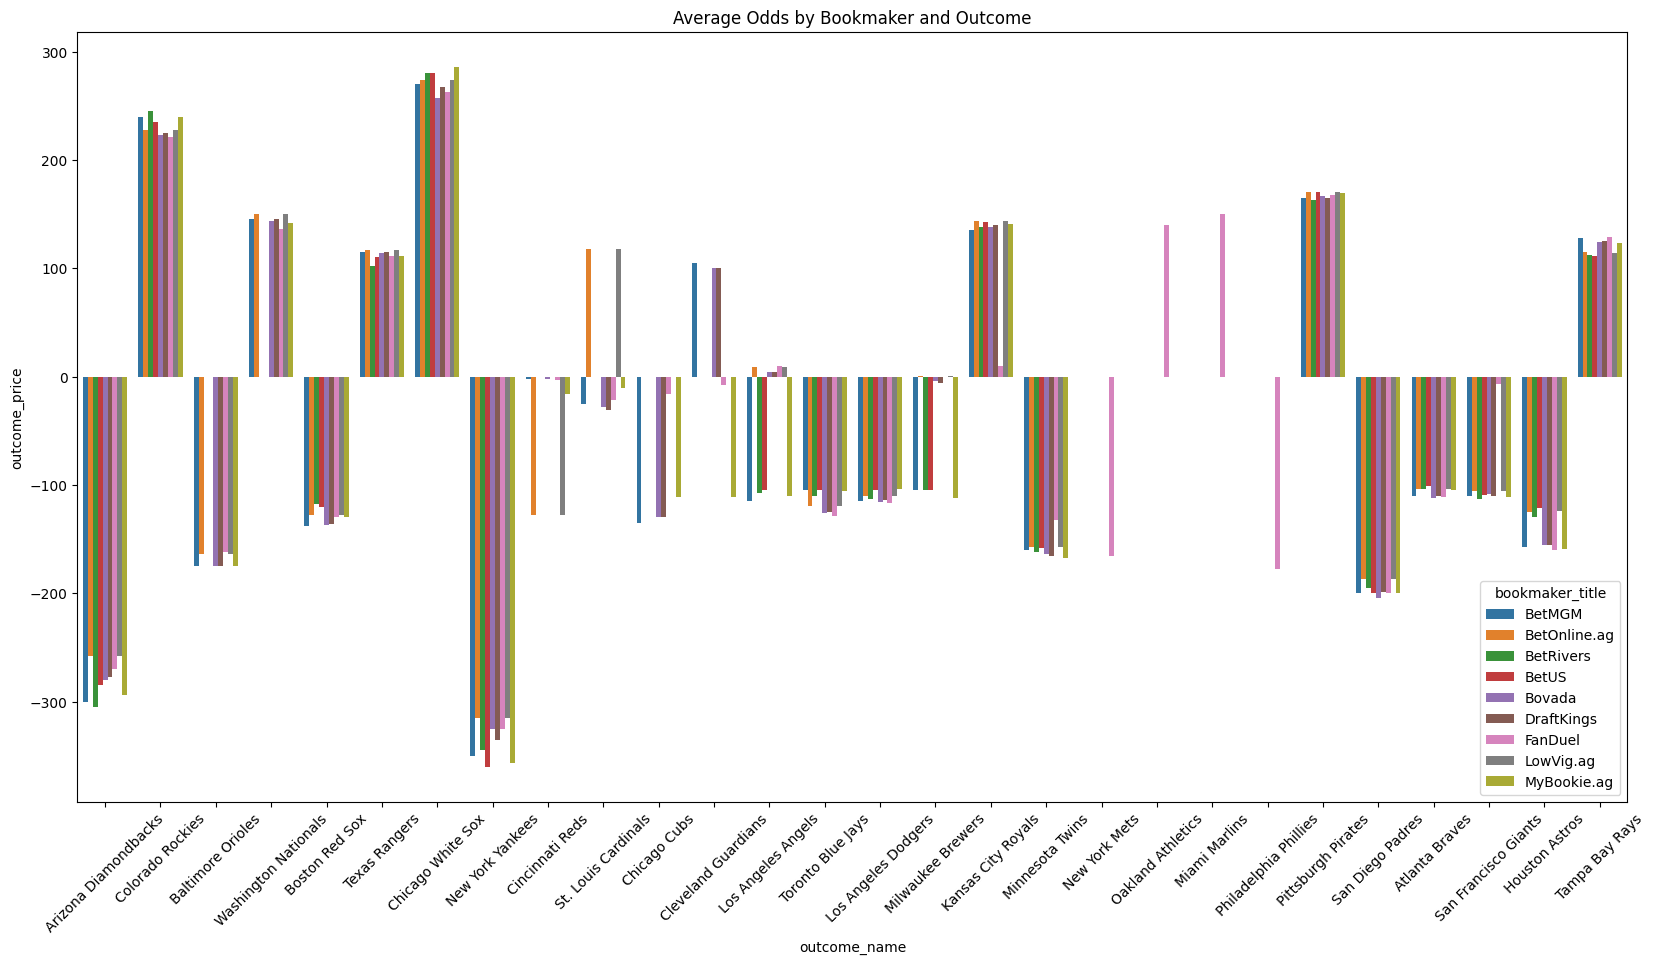

In [44]:
plt.figure(figsize=(20, 10))
sns.barplot(data=df_avg_odds, x='outcome_name', y='outcome_price', hue='bookmaker_title')
plt.title('Average Odds by Bookmaker and Outcome')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Groups and aggregates a processed Dataframe to find the average odds of each position of each market of each game
def av_odds(df):
    key_fields = ['sport_key', 'sport_title', 'home_team', 'away_team', 'market_key', 'outcome_name','outcome_price']

    # Aggregate by mean
    df = df.groupby(key_fields, dropna=False).mean()
    df.sort_values(['home_team', 'away_team', 'market_key'], inplace=True)
    return df


In [ ]:
# Extracts the pinnacle odds from processed odds (function will return an empty df if eu odds are not part of input df)
def extract_pinnacle(odds):
        pinnacle_odds = odds.loc[odds['book_key'] == 'pinnacle']
        pinnacle_odds.reset_index(drop=True, inplace=True)
        return pinnacle_odds


In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Merge the avg ev and pinnacle ev dataframes into one
def merge_ev(avg_merge, pinnacle_merge):
        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'book_key', 'book_title', 'market', 'position', 'line_book', 'point', 'num_outcomes', 'above_below_book', 'width_book', 'vig_win_dec_book', 'fair_win_dec_book', 'fair_line_book', 'amount_to_win_line_book', 'amount_to_win_fair_book', 'vig_dec_book', 'vig_pct_book']

        # Merge the dataframes (left merge because there are more averages than pinnacle odds and we don't want to lose those)
        final_merge = avg_merge.merge(pinnacle_merge.drop(columns=['num_books']), how='left', on=key_fields, suffixes=['_avg', '_pinnacle'])

        return final_merge

In [ ]:
# Takes API parameters and the desired type of expected value and returns a complete Dataframe with ev fields
def api_to_ev(api_key, sports=None, regions=['us'], markets=['h2h'], ev_type='both'):
        book_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=regions, markets=markets)

        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Reads data from a JSON file and returns a complete Dataframe with ev fields (if ev_type 'pinnacle' is selected and file does not contain eu odds, df will be empty)
def file_to_ev(filename, ev_type='both'):
        book_odds = file_to_processed_df(filename)
        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            pinnacle_odds = extract_pinnacle(book_odds)
            ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            pinnacle_odds = extract_pinnacle(book_odds)
            pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Filters a Dataframe of ev odds based on several optional parameters
def filter_ev(odds, pref_ev_filter, sports=None, markets=None, days_from_now=None, books=None, min_odds=None, max_odds=None, max_width=None, max_vig_pct=None, min_ev_pct=None, min_num_books=None):
        if sports is not None:
            odds = odds.loc[odds['sport_key'].isin(sports)]
        if markets is not None:
            odds = odds.loc[odds['market'].isin(markets)]
        if days_from_now is not None:
            date = pytz.UTC.localize(datetime.datetime.now())+datetime.timedelta(days=days_from_now)
            odds = odds.loc[odds['commence_time'].apply(lambda t: dateutil.parser.isoparse(t)) <=  date]
        if books is not None:
            odds = odds.loc[odds['book_key'].isin(books)]
        if min_odds is not None:
            odds = odds.loc[odds['line_book'] >= min_odds]
        if max_odds is not None:
            odds = odds.loc[odds['line_book'] <= max_odds]
        if max_width is not None:
            odds = odds.loc[odds['num_outcomes'] == 2]
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['width_avg'] <= max_width]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['width_pinnacle'] <= max_width]
        if max_vig_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['vig_pct_avg'] <= max_vig_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['vig_pct_pinnacle'] <= max_vig_pct]
        if min_ev_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['ev_pct_avg'] >= min_ev_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['ev_pct_pinnacle'] >= min_ev_pct]
        if min_num_books is not None:
            odds = odds.loc[odds['num_books'] >= min_num_books]

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Sorts a Dataframe of ev odds by a field
def sort_ev(odds, sortby, ascending, pref_ev_sort='avg'):
        if sortby == 'commence_time':
            odds.sort_values(['commence_time'], ascending=ascending, inplace=True)
        elif sortby == 'line':
            odds.sort_values(['line_book'], ascending=ascending, inplace=True)
        elif sortby == 'width':
            if pref_ev_sort == 'avg':
                odds.sort_values(['width_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['width_pinnacle'], ascending=ascending, inplace=True)
        elif sortby == 'ev_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['ev_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['ev_pct_pinnacle'], ascending=ascending, inplace=True)
        if sortby == 'kelly_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['kelly_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['kelly_pct_pinnacle'], ascending=ascending, inplace=True)

        if sortby == 'default':
            odds.sort_values(['commence_time', 'id', 'book_key', 'market'], inplace=True)

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Simplify the dataframe into a more easily consumable format
def cleanup_ev(odds, ev_type):
        fields_keep = ['sport_title', 'commence_time', 'home_team', 'away_team', 'book_title', 'market', 'position', 'line_book', 'point', 'num_books']

        if ev_type == 'both' or ev_type == 'avg':
            add_fields = ['fair_line_avg', 'width_avg', 'vig_pct_avg', 'ev_pct_avg', 'kelly_pct_avg']
            fields_keep.extend(add_fields)
        if ev_type == 'both' or ev_type == 'pinnacle':
            add_fields = ['fair_line_pinnacle', 'width_pinnacle', 'vig_pct_pinnacle', 'ev_pct_pinnacle', 'kelly_pct_pinnacle']
            fields_keep.extend(add_fields)


        odds = odds[fields_keep]
        odds = odds.round(2)
        return odds


In [ ]:
########################################################################################################################################
    #
    # BEGIN data() main code body
    #
    ########################################################################################################################################

    # Check inputs for api call and/or filename
if api_key is None and filename is None:
        raise SystemExit("Error: API key or filename must be specified\n")

if sports is None:
        if filename is None and api_key is not None:
            sports = get_sports(api_key=api_key)
elif sports is not None and (type(sports) != list or len(sports) == 0):
        raise TypeError("parameter 'sports' must be a list of valid sport IDs or None value. Refer to documentation for information on valid sport IDs\n")

if type(regions) != list or len(regions) == 0:
        raise TypeError("parameter 'regions' must be a list of valid regions. Refer to documentation for information on valid regions\n")

region_list = ['us']
for region in regions:
        if region not in region_list:
            raise SystemExit("Error: one or more regions are invalid. Refer to documentation for information on valid regions\n")

if type(markets) != list or len(markets) == 0:
        raise TypeError("parameter 'markets' must be a list of valid markets. Refer to documentation for information on valid markets\n")

market_list = ['h2h', 'spreads', 'totals']
for market in markets:
        if market not in market_list:
            raise SystemExit("Error: one or more markets are invalid. Refer to documentation for information on valid markets\n")

ev_types = ['avg', 'pinnacle', 'both']
if ev_type not in ev_types:
        raise SystemExit("Error: ev_type must be one of: 'avg', 'pinnacle', 'both' or be left blank")

NameError: name 'api_key' is not defined

In [ ]:
# Get ev data frame
    if filename is not None:
        df = file_to_ev(filename=filename, ev_type=ev_type)
    else:
        df = api_to_ev(api_key=api_key, sports=sports, regions=regions, markets=markets, ev_type=ev_type)

    # If recommended is on, reassign everything to values to give recommended bets (except books because a user should still be able to customize which books are displayed)
    if type(recommended) != bool:
        print("parameter 'recommended' must be a boolean. Default value is false")
        recommended = False
    if recommended:
        days_from_now = 2
        min_odds = -200
        max_odds = 200
        max_width = 45
        min_ev_pct = 1
        min_num_books = 4
        pref_ev_filter = 'both'
        sortby = 'ev_pct'
        ascending = False
        pref_ev_sort = 'avg'
        expanded = False

In [ ]:
# Check inputs for filter
    if days_from_now is not None and (type(days_from_now) != int or days_from_now < 0):
        if type(days_from_now) == float:
            days_from_now = int(days_from_now)
        else:
            print("parameter 'days_from_now' must be an integer >= 0. Filter parameter ignored")
            days_from_now = None

    if books is not None:
        if type(books) != list:
            print("parameter 'books' must be a list of valid book keys. Refer to documentation for information on valid books. Filter parameter ignored")
            books = None
        else:
            book_list = df['book_key'].unique().tolist()
            for book in list(books):
                if book not in book_list:
                    books.remove(book)
                    print(f'{book} is not a valid book. Data filtered by other specified books')
            if len(books) == 0:
                books = None

    if min_odds is not None and type(min_odds) != int and type(min_odds) != float:
        print("parameter 'min_odds' must be an integer or float. Filter parameter ignored")
        min_odds = None

    if max_odds is not None and type(max_odds) != int and type(max_odds) != float:
        print("parameter 'max_odds' must be an integer or float. Filter parameter ignored")
        max_odds = None

    if max_width is not None and type(max_width) != int and type(max_width) != float:
        print("parameter 'max_width' must be an integer or float. Filter parameter ignored")
        max_width = None

    if max_vig_pct is not None and type(max_vig_pct) != int and type(max_vig_pct) != float:
        print("parameter 'max_vig_pct' must be an integer or float. Filter parameter ignored")
        max_vig_pct = None

    if min_ev_pct is not None and type(min_ev_pct) != int and type(min_ev_pct) != float:
        print("parameter 'min_ev_pct' must be an integer or float. Filter parameter ignored")
        min_ev_pct = None

    if min_num_books is not None and type(min_num_books) != int and type(min_num_books) != float:
        print("parameter 'min_num_books' must be an integer or float. Filter parameter ignored")
        min_num_books = None

    if pref_ev_filter not in ev_types:
        print("parameter 'pref_ev_filter' must be one of: 'avg', 'pinnacle', 'both' or be left blank. Value defaults to 'both'")
        pref_ev_filter = 'both'
    elif pref_ev_filter == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_filter' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_filter = 'pinnacle'
    elif pref_ev_filter == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_filter' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_filter = 'avg'

    if ev_type == 'both':
        if pref_ev_filter is None:
            pref_ev_filter = 'both'
    else:
        pref_ev_filter = ev_type


In [ ]:
 # Filter the df
    df = filter_ev(df, pref_ev_filter, sports=sports, markets=markets, days_from_now=days_from_now, books=books, min_odds=min_odds, max_odds=max_odds, max_width=max_width, max_vig_pct=max_vig_pct, min_ev_pct=min_ev_pct, min_num_books=min_num_books)


In [ ]:
# Check inputs for sorting
    sort_options = ['commence_time', 'line', 'width', 'ev_pct', 'kelly_pct', 'default']
    if type(sortby) != str and sortby not in sort_options:
        print("parameter 'sortby' invalid. Refer to documentation for valid 'sortby' values. Filter parameter ignored")
        sortby = 'default'

    if ascending is not None and type(ascending) != bool:
        print("parameter 'ascending' must be a boolean. Default value used")
        ascending = False

    if pref_ev_sort is not None and (pref_ev_sort not in ev_types or pref_ev_sort == 'both'):
        print("parameter 'pref_ev_sort' must be 'avg' or 'pinnacle' or be left blank. Value defaults to 'avg'")
        pref_ev_sort = 'avg'
    elif pref_ev_sort == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_sort' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_sort = 'pinnacle'
    elif pref_ev_sort == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_sort' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_sort = 'avg'


In [ ]:
# Sort the df
    df = sort_ev(df, sortby=sortby, ascending=ascending, pref_ev_sort=pref_ev_sort)

In [ ]:
# If expanded is false, simplify the df
    if type(expanded) != bool:
        print("parameter 'expanded' must be a boolean. Value defaults to false.")
    if not expanded:
        df = cleanup_ev(df, ev_type=ev_type)

    return df